# Early Attempt

In [ ]:
import pandas as pd
import numpy as np
import re

import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()

In [ ]:
similes = pd.read_table('similes.txt', header=None, names=['simile'])

In [ ]:
len(similes)

In [ ]:
class Component():
    
    SUBJECT = 0
    OBJECT = 1
    TENOR = 2
    VEHICLE = 3
    GROUND = 4
    EVENT = 5
    
    _type = ''
    _phrase = []
    def __init__(self, type_, phrase):
        if type_ == self.SUBJECT:
            self._type = 'subject'
        elif type_ == self.OBJECT:
            self._type = 'object'
        elif type_ == self.TENOR:
            self._type = 'tenor'
        elif type_ == self.VEHICLE:
            self._type = 'vehicle'
        elif type_ == self.GROUND:
            self._type = 'ground'
        elif type_ == self.EVENT:
            self._type = 'event'
        else:
            raise ValueError('Unknown component type')
        
        if isinstance(phrase, list):
            self._phrase = phrase
        elif isinstance(phrase, Component):
            self._phrase = phrase._phrase
                
    def get_chain(self, index, reverse=False):
        if reverse:
            reverse = -1
        else:
            reverse = 1
            
        for item in self._phrase[::reverse]:
            yield item[index]
    
    def get_phrase(self, start, stop=None):
        if stop:
            return self._phrase[start:stop]
        
        return self._phrase[start]
            
    def slice(self, index):
        return self._phrase[:index], self._phrase[index:]
    
    def stitch(self):
        return ' '.join(list(self.get_chain(0)))
    
    def __str__(self):
        return f'{self._type}: {self._phrase}'
    
    def __repr__(self):
        return f'{self._type}: {self._phrase}'
    
class Tenor(Component):
    def __init__(self, phrase):
        super().__init__(Component.TENOR, phrase)
        
class Vehicle(Component):
    def __init__(self, phrase):
        super().__init__(Component.VEHICLE, phrase)
        
class Ground(Component):
    def __init__(self, phrase):
        super().__init__(Component.GROUND, phrase)
        
class Event(Component):
    def __init__(self, phrase):
        super().__init__(Component.EVENT, phrase)

In [ ]:
class Simile():
    
    MAX_LENGTH = 25
    
    _original = ''
    _word_tensor = None
    _comparator = ''
    _subject = None
    _object = None
    
    def __init__(self, text):
        self._original = text

    def build_tokens(self):
        n = nlp(self._original)
        tokens = [w.text for w in n][:self.MAX_LENGTH]
        poss = [w.pos_ for w in n][:self.MAX_LENGTH]

        empty_tensor = np.zeros((len(tokens), 1024))
        s = elmo.embed_sentence(tokens)[1]
        empty_tensor[:len(s), :] += s
        
        self._word_tensor = list(zip(tokens, poss, empty_tensor))
        return self
    
    
    
    def split_subject_object(self):
        _sub_obj_split = -1
        for i, elm in enumerate(self._word_tensor):
            if elm[0] == 'like':
                self._comparator = 'like'
                _sub_obj_split = i

            if elm[0] == 'as' and self._comparator == 'as':
                self._comparator = 'as...as'

            if elm[0] == 'as' and self._comparator == '':
                self._comparator = 'as'
                _sub_obj_split = i
                
        self._subject = Component(Component.SUBJECT, self._word_tensor[:_sub_obj_split])
        self._object = Component(Component.OBJECT, self._word_tensor[_sub_obj_split+1:])
        return self._subject, self._object
    
    def extract_components(self):
        tenor = Tenor([])
        vehicle = Vehicle([])
        ground = Ground([])
        event = Event([])
        
        if self._comparator == 'like':
            index = 1
            for p in self._subject.get_chain(1, reverse=True):
                if p == 'VERB':
                    tenor, event = self._subject.slice(-index)
                    break
                index += 1
                
            tenor = Tenor(tenor)
            vehicle = Vehicle(self._object)
            event = Event(event)
            
#             print(list(self._subject.get_chain(1)))
#             print(list(self._object.get_chain(1)))
            
        elif self._comparator == 'as':
            index = 0
            prev = ''
            for p in self._subject.get_chain(1, reverse=True):
                if index > 0 and p in ['NOUN', 'PUNCT'] and prev in ['ADJ', 'ADV']:
                    nnp = index
                    break
                prev = p
                index += 1

            if index > 0:
                ground, tenor = self._subject.slice(-index)
                ground, tenor = Ground(ground), Tenor(tenor)
            else:
                tenor = Tenor(self._subject)

            if tenor.get_phrase(0)[1] == 'VERB':
                event, tenor = tenor.slice(1)
                event, tenor = Event(event), Tenor(tenor)
            elif tenor.get_phrase(-1)[1] == 'VERB':
                tenor, event = tenor.slice(-1)
                tenor, event = Tenor(tenor), Event(event)
                
            vehicle = Vehicle(self._object)
            
        elif self._comparator == 'as...as':
        
            text_parts = {'ground': [], 'vehicle': []}

            index = 0
            for w in self._object.get_chain(0):
                if w == 'as':
                    ground, vehicle = self._object.slice(index)
                index += 1

            if self._subject.get_phrase(-1)[1] == 'VERB':
                tenor, event = self._subject.slice(-1)
                tenor, event = Tenor(tenor), Event(event)
            else:
                tenor = Tenor(self._subject)

            ground = Ground(ground)
            vehicle = Vehicle(vehicle[1:])
    
        return tenor, vehicle, ground, event
    
    def __repr__(self):
        return f'{self._original}\n{self._comparator}'

In [ ]:
# def chunk(simile):
#     s = Simile(simile).build_tokens()
#     s.split_subject_object()
#     comps = s.extract_components()
        
#     return {
#         'tenor': comps[0].stitch(),
#         'vehicle': comps[1].stitch(),
#         'ground': comps[2].stitch(),
#         'event': comps[3].stitch(),
#     }

In [ ]:
s = 'A shadow of melancholy touched her lithe fancies, as a cloud dims the waving of golden grain'

Simile(s).build_tokens()


In [ ]:
d = pd.DataFrame().from_records(similes['simile'].apply(lambda r: chunk(r)))

In [49]:
d.sample(5)

,comparator,event,ground,tenor,vehicle
54,as...as,None,pale,A stooping girl,a pearl
115,like,maddens the soul,None,Beauty,wine
303,like,turned on me,None,He,a thunder cloud
437,as,was,None,It,if a door had been opened into a furnace so th...
875,like,felt I,None,Then,some watcher of the skies


# Measures of Similarity

Making use of ELMO

In [23]:
chnk = chunk('The car is as clean as a washed slate')

tenor_vec = np.array([w['vec'] for w in chnk['subject'][:-1]]).mean(axis=0)
ground_vec = np.array([chnk['subject'][-1]['vec']]).mean(axis=0)
vehicle_vec = np.array([w['vec'] for w in chnk['object'][1:]]).mean(axis=0)

tenor_vec.shape, ground_vec.shape, vehicle_vec.shape

((1024,), (1024,), (1024,))

In [18]:
chnk = chunk('She is as burnt as a blue whale')

tenor_vec2 = np.array([w['vec'] for w in chnk['subject'][:-1]]).mean(axis=0)
ground_vec2 = np.array([chnk['subject'][-1]['vec']]).mean(axis=0)
vehicle_vec2 = np.array([w['vec'] for w in chnk['object'][1:]]).mean(axis=0)

tenor_vec2.shape, ground_vec2.shape, vehicle_vec2.shape

((1024,), (1024,), (1024,))

In [24]:
1-pdist([tenor_vec, tenor_vec2], 'cosine'), 1-pdist([ground_vec, ground_vec2], 'cosine'), 1-pdist([vehicle_vec, vehicle_vec2], 'cosine')

(array([0.54225752]), array([0.78717851]), array([0.69348162]))

In [112]:
tokens1 = [w.text for w in nlp('Her battle against cancer raged on')]
tokens2 = [w.text for w in nlp('The journey through cancer was long')]

sents = [tokens1, tokens2]

ws_d0 = []
ws_d1 = []
ws_d2 = []


for v in elmo.embed_sentences(sents):
    empty_tensor = np.zeros((15, 1024))
#     ws_d0.append(v[0][:6])
#     ws_d1.append(v[1][:6])
#     ws_d2.append(v[2][:6])
    print(v[1].shape)
    empty_tensor[:len(v[1]), :] += v[1]
    print(empty_tensor.shape)
    
ws_d0, ws_d1, ws_d2 = np.array(ws_d0), np.array(ws_d1), np.array(ws_d2)

(6, 1024)
(15, 1024)
(6, 1024)
(15, 1024)


In [ ]:
from scipy.spatial.distance import cdist, pdist

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

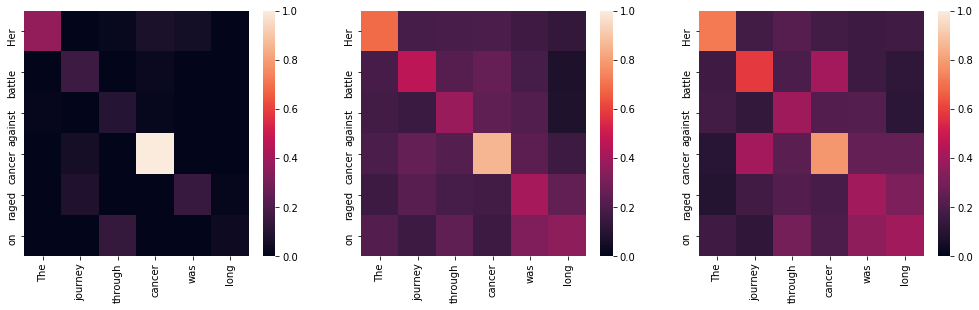

In [97]:
plt.subplots(figsize=(14,4))
plt.tight_layout()
plt.subplot(131)
sns.heatmap(1-cdist(ws_d0[0], ws_d0[1], 'cosine'), yticklabels=tokens1[:6], xticklabels=tokens2[:6], vmin=0, vmax=1)

plt.subplot(132)
sns.heatmap(1-cdist(ws_d1[0], ws_d1[1], 'cosine'), yticklabels=tokens1[:6], xticklabels=tokens2[:6], vmin=0, vmax=1)

plt.subplot(133)
sns.heatmap(1-cdist(ws_d2[0], ws_d2[1], 'cosine'), yticklabels=tokens1[:6], xticklabels=tokens2[:6], vmin=0, vmax=1)

In [104]:
(1-cdist(ws_d0[0], ws_d0[1], 'cosine')).mean(), (1-cdist(ws_d2[0], ws_d2[1], 'cosine')).mean()

(0.03195305364545267, 0.25118495995725143)

## Early Rule-based solution

In [ ]:
def get_text(phrase):
    return ' '.join([w['text'].text for w in phrase if w['pos'] != 'PUNCT'])

def chunk(simile):
        
    # determine the subject and the object of the simile
    syntax = {'subject': [], 'object': []}
    
    key = 'subject'
    comparator = ''
    tokens = []
    
    for w, vec in zip(n, empty_tensor):
        if w.text == 'like':
            comparator = 'like'
            key = 'object'
            
        if w.text == 'as' and comparator == 'as':
            comparator = 'as...as'
            
        if w.text == 'as' and comparator == '':
            comparator = 'as'
            key = 'object'
        
        # store the word text, its POS, and its vector
        syntax[key].append({'text': w, 'pos': w.pos_, 'vec': vec})
                    
    tenor = None
    ground = None
    vehicle = None
    event = None
    tenor_vec = None
    ground_vec = None
    vehicle_vec = None
    event_vec = None
    
#     return syntax
    
    if comparator == 'as...as':
        
        text_parts = {'ground': [], 'vehicle': []}
        vec_parts = {'ground': [], 'vehicle': []}
        
        key = 'ground'
        for w in syntax['object'][1:]:
            if w['text'].text == 'as':
                key = 'vehicle'
                continue
                
            text_parts[key].append(w)
            vec_parts[key].append()
        
        
        if syntax['subject'][-1]['pos'] == 'VERB':
            event = syntax['subject'][-1]['text']
            tenor = get_text(syntax['subject'][:-1])
        else:
            tenor = get_text(syntax['subject'])
            
        ground = get_text(parts['ground']) # good
        vehicle = get_text(parts['vehicle']) # good
                
    elif comparator == 'like':
        parts = {'tenor': [], 'event': []}
        
        key = 'event'
        for w in syntax['subject'][::-1]:
            parts[key].append(w)
            if w['pos'] == 'VERB':
                key = 'tenor'
                
        if not parts['tenor']:
            event_verbs = [1 for e in parts['event'] if e['pos'] == 'VERB']
            if sum(event_verbs) == 0:
                parts['tenor'] = parts['event']
                parts['event'] = []
        
        tenor = get_text(parts['tenor'][::-1])
        event = get_text(parts['event'][::-1])
        vehicle = get_text(syntax['object'][1:])
            
    elif comparator == 'as':
        
        nnp = 0
        for i, w in enumerate(syntax['subject'][::-1]):
            if i > 0 and w['pos'] in ['NOUN', 'PUNCT'] and syntax['subject'][-i]['pos'] in ['ADJ', 'ADV']:
                nnp = i
                                
        if nnp > 0:
            ground = get_text(syntax['subject'][-nnp:])
            tenor = syntax['subject'][:-nnp]
        else:
            tenor = syntax['subject']
            
        if tenor[0]['pos'] == 'VERB':
            event = tenor[0]['text']
            tenor = tenor[1:]
        elif tenor[-1]['pos'] == 'VERB':
            event = tenor[-1]['text']
            tenor = tenor[:-1]
            
        tenor = get_text(tenor)
            
        vehicle = get_text(syntax['object'][1:])
        
    return {'tenor': tenor, 'ground': ground, 'vehicle': vehicle, 'event': event, 'comparator': comparator}